# Fruit Inspection - Exercise 1

## Importing the needed libraries

In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
print(os.getcwd())

C:\Users\aleda\Documents\GitHub\FruitDefectsInspection


## Tools

In [2]:
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

def plot_images_row(imgs, title = ""):

  imgs_dim = [img.shape for img in imgs]
  max_rows = max([img_dim[0] for img_dim in imgs_dim])
  max_cols = max([img_dim[1] for img_dim in imgs_dim])
  
  cropped_imgs = []
  for i in imgs:
   cropped_imgs.append(cv2.copyMakeBorder(i,0, max_rows-i.shape[0], 0, max_cols - i.shape[1],cv2.BORDER_REPLICATE))

  fig = plt.figure(1, (14, 5))
  fig.suptitle(title, fontsize=16)
  grid = ImageGrid(fig, 111, # similar to subplot(111)
                  nrows_ncols = (1, len(imgs)), # creates 2x2 grid of axes
                  axes_pad=0.1, # pad between axes in inch.
                  )

  for i in range(len(imgs)):
      grid[i].imshow(cropped_imgs[i], cmap='gray') # The AxesGrid object work as a list of axes.

  plt.show()


def show_masking_effect(binary_mask, color_image, show_output=False, transparency=0.7):
    background = color_image
    overlay = np.stack([ binary_mask, np.zeros(binary_mask.shape, dtype=np.uint8), np.zeros(binary_mask.shape,np.uint8)], axis=2)
    added_image = cv2.addWeighted(background,0.9,overlay,transparency,0)

    if show_output:
        plt.imshow(added_image, cmap="gray")
        plt.title("Image + binary mask overlay")
        plt.show()
    
    return added_image 

## Importing the images

### Black and white images

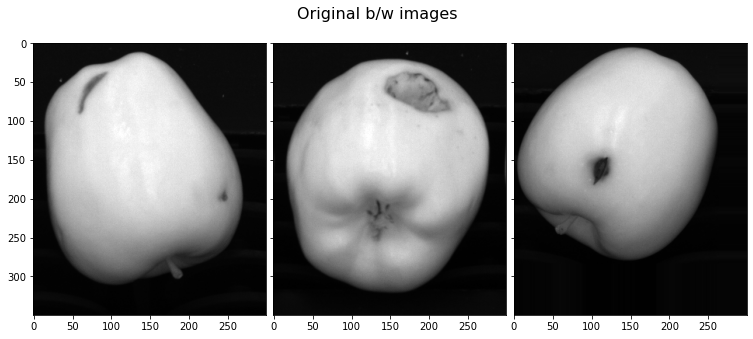

In [3]:
imgs = [cv2.imread(f"./first task/src/C0_00000{i}.png",cv2.IMREAD_GRAYSCALE) for i in range (1,4)]
plot_images_row(imgs, title = "Original b/w images")

### Color images

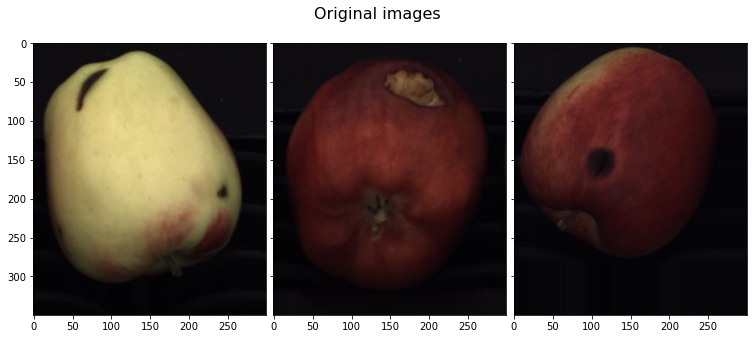

In [4]:
color_imgs = [cv2.imread(f"./first task/src/C1_00000{i}.png") for i in range (1,4)]
color_imgs = [cv2.cvtColor(i,cv2.COLOR_BGR2RGB) for i in color_imgs]
plot_images_row(color_imgs, title = "Original images")

### Checking parallax

Checking if the sizes of b/w images and color images correctly match
[(350, 300), (350, 300), (285, 265)]
[(350, 300, 3), (350, 300, 3), (285, 265, 3)]



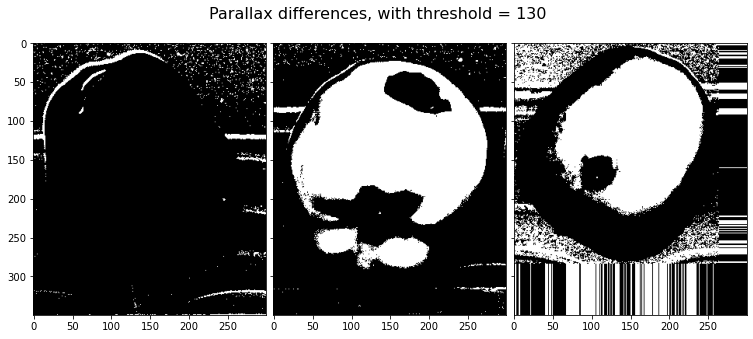

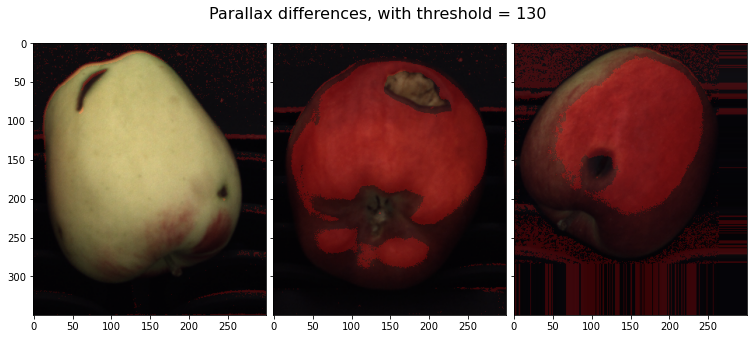

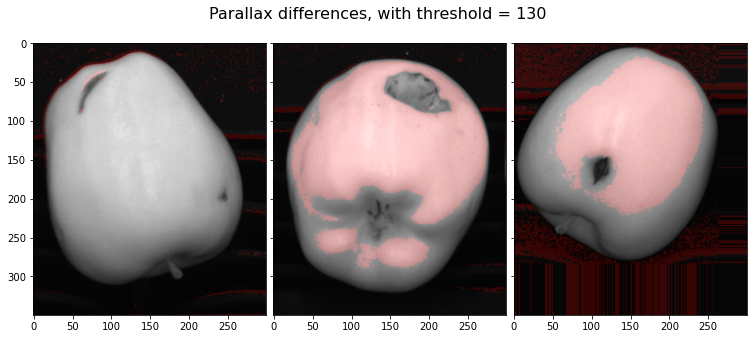

In [5]:
print("Checking if the sizes of b/w images and color images correctly match")
print([i.shape for i in imgs])
print([i.shape for i in color_imgs])
print()

parallax_difference = [np.array(abs(imgs[i] - cv2.cvtColor(color_imgs[i], cv2.COLOR_RGB2GRAY))) for i in range(len(imgs))]
thresh = 130
parallax_mask = [(parallax_difference[i]>thresh).astype(np.uint8)*255 for i in range(len(imgs))]
plot_images_row(parallax_mask, title = f"Parallax differences, with threshold = {thresh}")

overlay_parallax_color = [show_masking_effect(parallax_mask[i], color_imgs[i], transparency=0.2) for i in range(len(imgs))]
overlay_parallax_bw = [show_masking_effect(parallax_mask[i], cv2.cvtColor(imgs[i], cv2.COLOR_GRAY2RGB), transparency=0.2) for i in range(len(imgs))]
plot_images_row(overlay_parallax_color, title = f"Parallax differences, with threshold = {thresh}")
plot_images_row(overlay_parallax_bw, title = f"Parallax differences, with threshold = {thresh}")

We can easily see that there's little parallax (some overlayed zones are caused because of the different conversion from color to gray levels). 

Some minor differences in the final highlighted defects (in the original gray level image with respect to the original color image) is expected, as we can see from the images above.

## Intensity Histograms

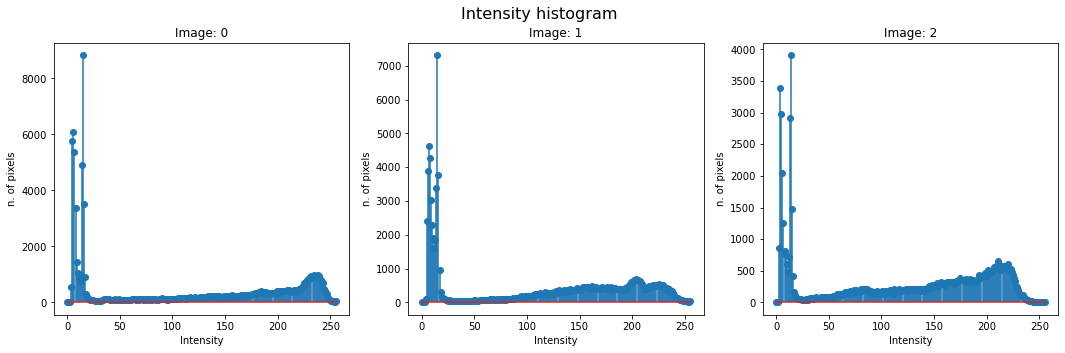

In [6]:
def plot_intensity_hists(hists, fig_size=(18,5),thresh=None):

    fig, axs = plt.subplots(1, len(hists))
    fig.set_size_inches(fig_size[0], fig_size[1])
    fig.suptitle("Intensity histogram", fontsize=16)

    for i in range(len(hists)):
        axs[i].stem(hists[i],use_line_collection=True) # The AxesGrid object work as a list of axes.
        axs[i].set_title(f"Image: {i}")
        if thresh:
          axs[i].axvline(thresh, color='r', label="manual threshold")
          axs[i].legend()
        axs[i].set_xlabel("Intensity")
        axs[i].set_ylabel("n. of pixels")
    plt.show()


hists = [ np.histogram(i.flatten(), 256, [0,256])[0] for i in imgs]
plot_intensity_hists(hists)

The histogram is bimodal: we can see a peak between intensites 200 and 250 and another peak between 0 and 50. Unfortunately, many pixels are spread over intermediate intensities and this will require a cautious study.

## Thresholding

In order to binarize the image it is necessary to choose a thresholding method. We'll compare three methods:


*   Manual threshold selection
*   Peaks Method
*   OTSU



### Manual Threshold selection

In [7]:
def manual_mask(img, threshold):
    ''' 
    This function applies the binarization of the image through the use of a manual threshold
    
    img: the image to be binarized
    threshold: the manual threshold
    '''
    return [[0 if j < threshold else 255 for j in i] for i in img]

#### Visualizing the manual threshold in the histogram

Minimas:  [26, 33, 26] Average minimum:  28


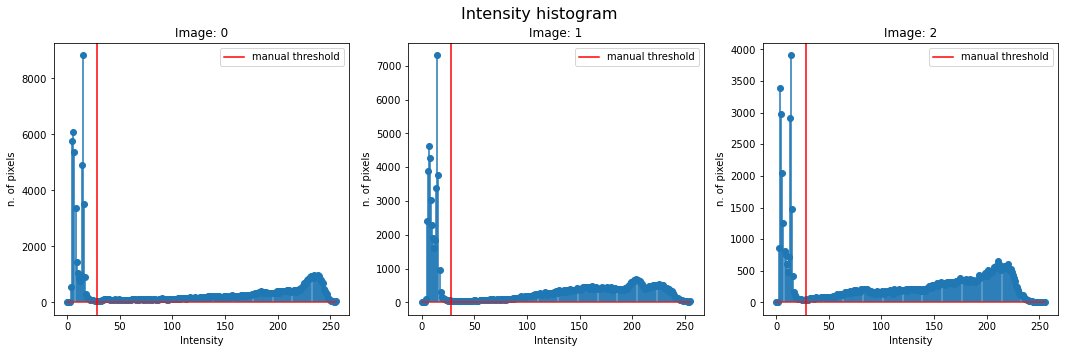

In [8]:
peak_domain=[15,200] #domain in which the minimas have to be found
# we choose the threshold value as the mean between the minimas of the histogram (corresponding to the least numerous intensities)
mins_hists = [peak_domain[0] + np.argmin(hist[peak_domain[0]:peak_domain[1]]) for hist in hists] 
average_min = int(np.average(mins_hists))
print("Minimas: ", mins_hists, "Average minimum: ", average_min)
plot_intensity_hists(hists, thresh=average_min)

Obtaining the following binary mask:

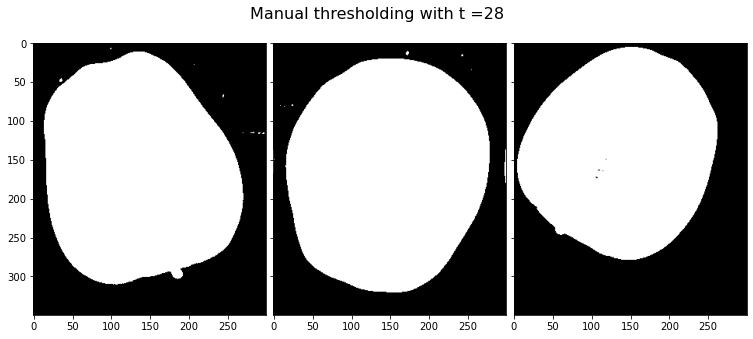

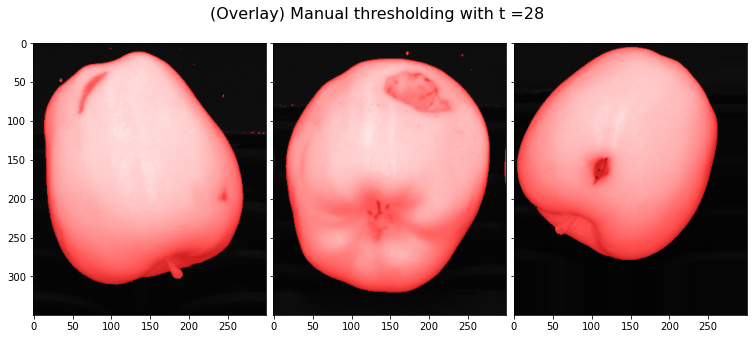

In [9]:
manual_masks = [np.array(manual_mask(i, average_min), dtype=np.uint8) for i in imgs]
manual_imgs = [show_masking_effect(manual_masks[i], cv2.cvtColor(imgs[i],cv2.COLOR_GRAY2RGB)) for i in range(len(imgs))]

plot_images_row(manual_masks, title = f"Manual thresholding with t ={average_min}")
plot_images_row(manual_imgs, title = f"(Overlay) Manual thresholding with t ={average_min}")

PROs and CONs of using Manual Threshold:

**PROs**
*   **Speed**: thresholds are implemented using LUTs, which are very fast to apply and that are even faster with devices like FPGAs. Speed is a crucial requirement in industrial scenarios.
*   **Good under controlled conditions**: The threshold selected succeeds in segmenting the whole apple.

**CONs**
*   **Not robust to light changes**: if the light changes, the manual threshold could not be the same as the one set originally: robustness is not guaranteed. 

### OTSU's

#### OTSU only

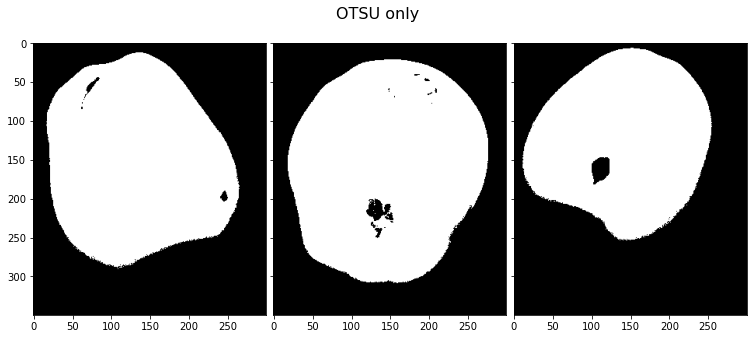

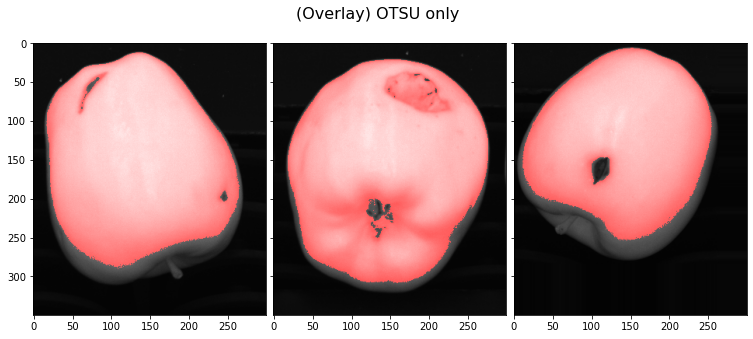

In [10]:
otsu_masks = [cv2.threshold(i,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1] for i in imgs]

otsu_imgs = [show_masking_effect(otsu_masks[i], cv2.cvtColor(imgs[i],cv2.COLOR_GRAY2RGB)) for i in range(len(imgs))]

plot_images_row(otsu_masks, title = "OTSU only")
plot_images_row(otsu_imgs, title = "(Overlay) OTSU only")

PROs and CONs of using (plain) OTSU:

**PROs**

*   **Automatic method**: The threshold is selected automatically, avoiding manual intervention and changing depending on the intensity distribution of the image in object 

**CONs**
*   **Bad segmentation result**

#### Gamma correction + OTSU

#### Gamma correction (aka Exponential Operator)

It is sometimes desirable to selectively enhance the contrast in either dark (under-exposed) or bright (over-exposed) areas of the image. Linear stretching, though, would expand the contrast uniformly. However, a non-linear mapping, such as the Exponential Operator, can be deployed:

<img src="gdrive/MyDrive/fruitinspection/gamma_correction.png" width="320">

Thus, taking $r<1$ would stretch the intensity dynamics of dark areas and shrink that of bright ones, which turns out effective to improve under-exposed images. The opposite behaviour is achieved with $r>1$, which therefore can be used to enhance over-exposed images.

Given an exponent $r$, $P_{out}$ the output pixel value and $P_{in}$ the input pixel value, the formula for the exponential operator is the following:

$P_{out}=255*(\frac{P_{in}}{255})^r$

In our case, the aim is to make the peaks corresonding to the bright areas and to the dark areas more evident and, thus, to make the two classes of intensity more "separable". The pixels that should be binarized as white (bright) occupy a wider range of intensities in the original histograms: to stretch that range, I'll need to use r < 1.

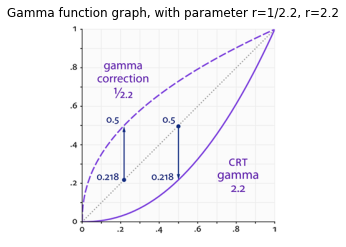

In [11]:
plt.imshow(cv2.imread("./other/gamma_correction.png"))
plt.axis('off')
plt.title("Gamma function graph, with parameter r=1/2.2, r=2.2")
plt.show()

In [12]:
def gammaFunction(r, displacement=0):
    table = [((max(i+displacement,0) / 255) ** r) * 255 for i in range(256)]
    table = np.array(table, np.uint8)
    return table


def gammaCorrection(img, r):
    table = gammaFunction(r)
    return cv2.LUT(img, table)


def gamma_otsu(img, r):
    filtered_img = gammaCorrection(img,r)
    th_value,th = cv2.threshold(filtered_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    return th

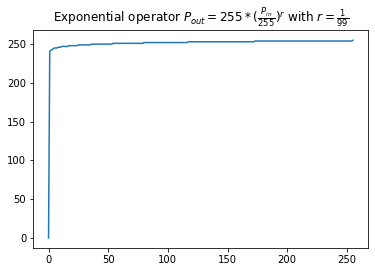

In [13]:
r = 1/99
plt.plot(gammaFunction(r=r))
plt.title(r"Exponential operator $P_{out} = 255*(\frac{P_{in}}{255})^r$ with $r=\frac{1}{99}$")
plt.show()

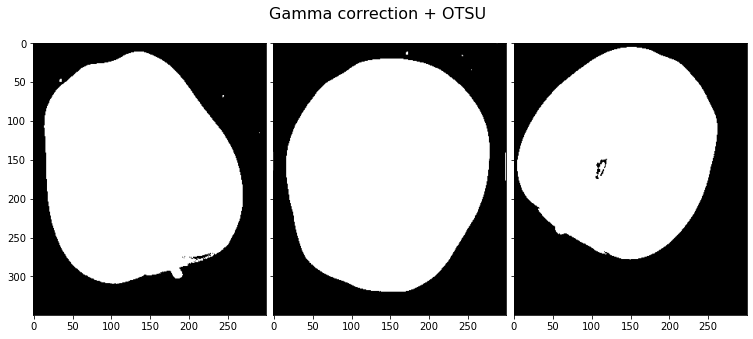

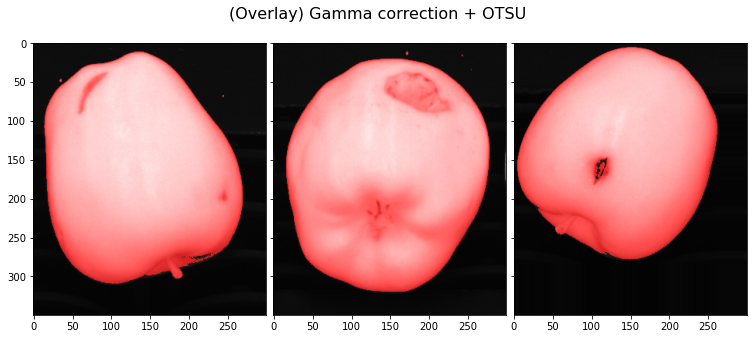

In [14]:
r = 1/99
gamma_otsu_masks = [gamma_otsu(img=i,r=r) for i in imgs]

gamma_otsu_imgs = [show_masking_effect(gamma_otsu_masks[i], cv2.cvtColor(imgs[i],cv2.COLOR_GRAY2RGB)) for i in range(len(imgs))]

plot_images_row(gamma_otsu_masks, title = "Gamma correction + OTSU")
plot_images_row(gamma_otsu_imgs, title = "(Overlay) Gamma correction + OTSU")

PROs and CONs of using Gamma correction + OTSU:

**PROs**


*   **Good segmentation result**

*   **Automatic method**: The threshold is selected automatically, avoiding manual intervention and changing depending on the intensity distribution of the image in object 

**CONs**

*   **gamma function parameter (r) is set manually**

*   **Not robust for intermediate grey levels**: The gamma correction function is almost a step function: the nearby intensities could be pushed far from similar intensities in the obtained histogram. The parameter r of the gamma correction function is even more delicate than the manual threshold (Small variations lead to worse results). 

#### Custom function + OTSU

To remap the intensity values in the original intensity histogram to a set of values in which OTSU can give better results, I've realized a LUT with a custom function that is similar to a gamma function but with a sigmoid-like ramp. This should be slightly more robust than the solution that uses the gamma correction, since the "elbow" is less steep (therefore, gray levels in neighboring regions are mapped in a less "drastic" way). 

In [15]:
def sigmoidHillFunction(displacement):
    table = [1/(1+np.e**(-(i-11)))*256 for i in np.linspace(0,10,  displacement + 1)]
    #table = np.array(table, np.uint8)

    return table


def customFunction(displacement = -28):
    r = 1/8
    table = gammaFunction(r,displacement)
    sigmoid = sigmoidHillFunction(-displacement)
    table = np.array([sigmoid[i] if i<=(-displacement) else table[i] for i in range(len(table))], np.uint8)
    return table


def customFunctionCorrection(img, displacement = -28):
    table = customFunction(displacement)
    return cv2.LUT(img, table)


def customFunctionOtsu(img, displacement = -28):
    filtered_img = customFunctionCorrection(img, displacement)
    th_value,th = cv2.threshold(filtered_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return th

#### Graph of the custom function

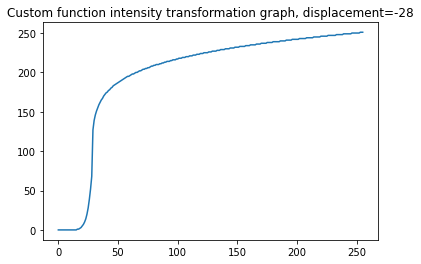

In [16]:
displacement = -28
plt.plot(customFunction(displacement=displacement))
plt.title(f"Custom function intensity transformation graph, displacement={displacement}")
plt.show()

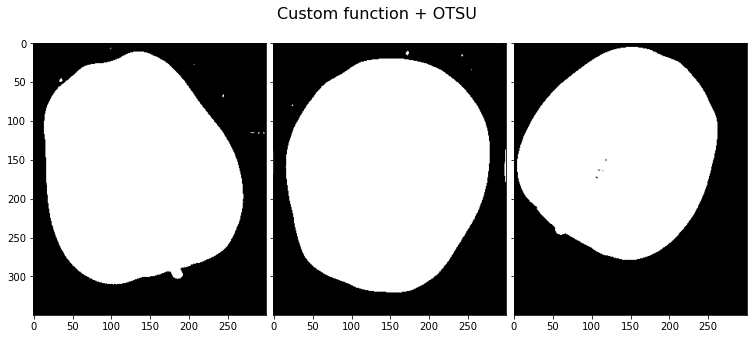

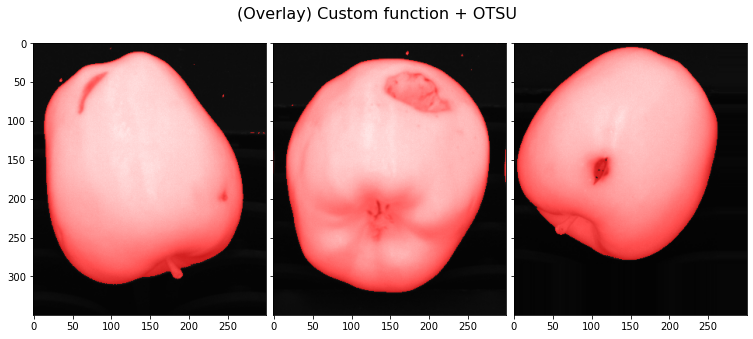

In [17]:
custom_otsu_masks = [customFunctionOtsu(i) for i in imgs]

custom_otsu_imgs = [show_masking_effect(custom_otsu_masks[i], cv2.cvtColor(imgs[i],cv2.COLOR_GRAY2RGB)) for i in range(len(imgs))]
plot_images_row(custom_otsu_masks, title = "Custom function + OTSU")
plot_images_row(custom_otsu_imgs, title = "(Overlay) Custom function + OTSU")

PROs and CONs of using Custom Function + OTSU:

**PROs**


*   **Good segmentation result**

*   **Automatic method**: The threshold is selected automatically, avoiding manual intervention and changing depending on the intensity distribution of the image in object 

**CONs**

*   **displacement parameter (which determines ramp position) is set manually**

## Morphological Transformations: Opening and Closing

The obtained mask is quite good, but can be furtherly improved through the use of Morphological Transformations. Below, *opening* and *closing* operators have been used:

Morphological operations used:

*   **closing** with a 5x5 circle
*   **opening** with a 4x4 square   


**N.B.**: From here on I'll proceed using the Custom function + 
OTSU, but in case a faster method is required and lighting conditions are known to be stable, manual thresholding can be used. 

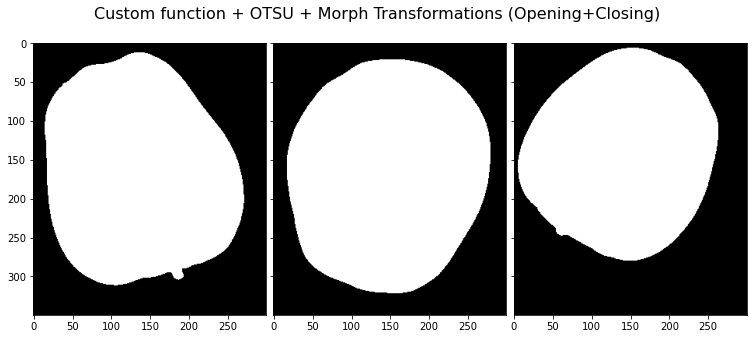

In [18]:
def customFunctionOtsuMorph(img, show_output=False, displacement = -28):
    '''
    In this implementation, Custom function + OTSU is applied,
    Morph Transformations (closing with a 5x5 circle, opening with a 4x4 square) following it


    img: The image to apply Custom function + OTSU + Morph Transformations (Opening+Closing) on
    show_output: True if the obtained image has to be printed
    '''
    custom_otsu_mask = customFunctionOtsu(img, displacement)
    
    kernel_closing = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    kernel_opening = np.ones((4,4))

    morphed_mask = cv2.morphologyEx(custom_otsu_mask, cv2.MORPH_CLOSE, kernel_opening)
    morphed_mask = cv2.morphologyEx(morphed_mask, cv2.MORPH_OPEN, kernel_closing)

    if show_output:
        plt.imshow(morphed_mask, cmap="gray")
        plt.title("Custom Function Point Operator + OTSU + Morph")
        plt.show()

    return morphed_mask

custom_otsu_masks = [customFunctionOtsuMorph(i) for i in imgs]

plot_images_row(custom_otsu_masks, title = "Custom function + OTSU + Morph Transformations (Opening+Closing)")
#plot_images_row(gamma_otsu_imgs, title = "(Overlay) Custom function + OTSU")

## Flood filling 



In order to make a mask that is covering the whole fruit (avoiding holes inside it), it is needed to flood fill the fruit shape. To obtain this result, the below function:


1.   Inverts the input image
2.   Flood fills the surroundings of the fruit (the fruit shape outer pixels) with black (0). In this way, just the dark regions *inside* the shape are highlighted (in white, 255).
3.   Performs an OR between the original image and the image obtained in the step before, obtaining the deletion of the inner holes. The result is a cleaner mask.


The process is similar to the one described [here](https://learnopencv.com/filling-holes-in-an-image-using-opencv-python-c/).

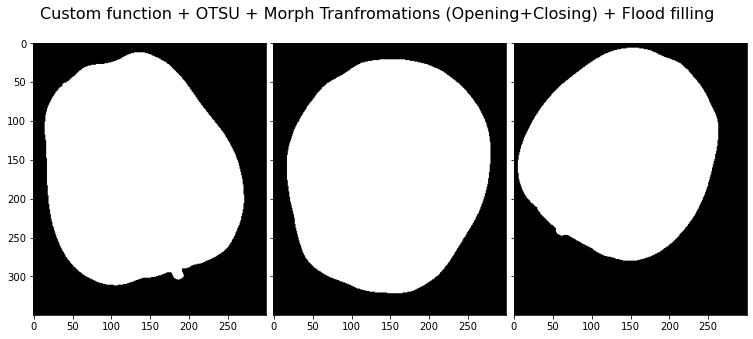

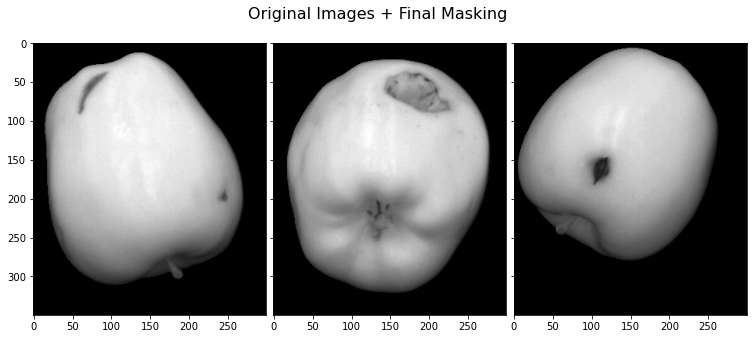

In [19]:
def floodFillBackground(src_image, show_output=False):

    image = src_image.copy()
    image_inverse = cv2.bitwise_not(image)

    h, w = image.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    canvas = np.zeros((h + 2, w + 2), np.uint8)

    # Flood filling blackground with black pixels starting from left up corner
    cv2.floodFill(image_inverse,mask, (0, 0), 0)

    im_out = image_inverse | image

    if show_output:
        plt.imshow(im_out, cmap="gray")
        plt.title("Flood filled background")
        plt.show()

    return im_out


floodFilledImages = [floodFillBackground(i) for i in custom_otsu_masks]

plot_images_row(floodFilledImages, title = "Custom function + OTSU + Morph Tranfromations (Opening+Closing) + Flood filling")

masked_images = [cv2.bitwise_and(imgs[i],floodFilledImages[i]) for i in range(len(imgs))]

plot_images_row(masked_images, title = "Original Images + Final Masking")




## (Canny's) Edge Detection

In order to locate the defects, Canny edge detection algorithm is used. 

In order to complete the original idea of Canny, the image is gaussian-filtered before calling the OpenCv implementation ``cv2.Canny``. 

Furthermore, a final dilation pass (with a 3x3 cross) is done to fill possible holes in the borders.  

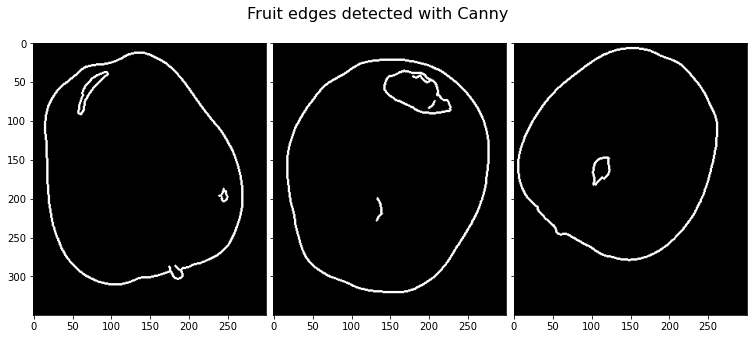

In [20]:
def cannyEdgeDetectionClosing(img, blurring_dim, canny_low, canny_high, show_output=False):
    '''
    This function proceeds:
    1. Filtering the image with a gaussian filter
    2. Applying OpenCv's Canny algorithm implementation (to find edges)
    3. Applying a final closing stage

    img: the image to which the whole process has to be applied
    blurring_dim: the kernel size for the gaussian filtering
    canny_low: the lower threshold for Canny's algorithm
    canny_high: the high threshold for Canny's algorithm

    returns: the edges of the original img
    '''
    im = img.copy()
    # Gaussian filtering
    im = cv2.GaussianBlur(im,(blurring_dim,blurring_dim),0)

    # Canny's OpenCv edge detection
    edges = cv2.Canny(im,canny_low,canny_high)
    
    # dilating by 3x3 cross
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    edges = cv2.dilate(edges, kernel_dilate)
    if show_output:
        plt.imshow(edges, cmap="gray")
        plt.title("Canny edge detection + Closing")
        plt.show()

    return edges


edges = [cannyEdgeDetectionClosing(i,blurring_dim=7,canny_low=60,canny_high=130) for i in masked_images]

plot_images_row(edges, title = "Fruit edges detected with Canny")


#### Main borders removal
If we want to operate directly on the edge defects and later fill em, we should first delete the overall contour of the fruit: this can be done performing an erosion.
Notice that if instead the deletion of the main border would have been based on some features like its (filled) area or similar, then some defects nearby the borders could have been later ignored by the location detection process.

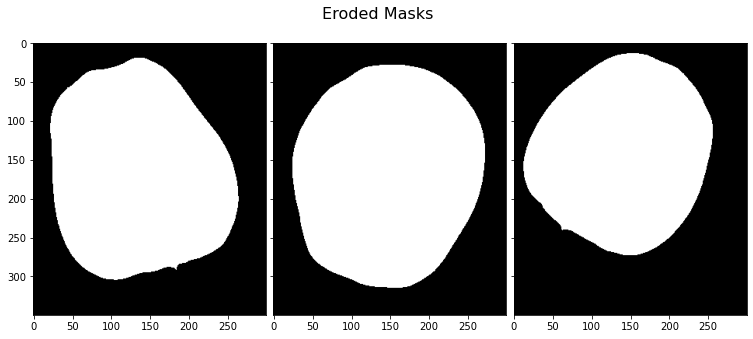

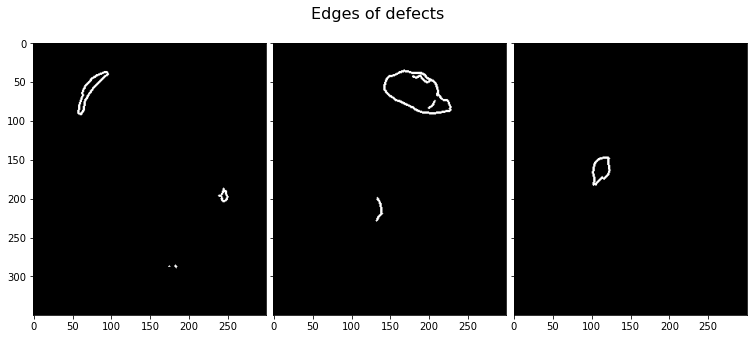

In [21]:
def erodeMask(mask, show_output=False):
    im = mask.copy()
    erosion_size=7
    erosion_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2 * erosion_size + 1, 2 * erosion_size + 1))
    erosion_dst = cv2.erode(im, erosion_element)

    if show_output:
        plt.imshow(mask,cmap="gray")
        plt.title("Eroded mask")
        plt.show()
    return erosion_dst

eroded_masks = [erodeMask(i) for i in floodFilledImages]
defects_edges = [cv2.bitwise_and(eroded_masks[i],edges[i]) for i in range(len(eroded_masks))]

plot_images_row(eroded_masks, title = "Eroded Masks")
plot_images_row(defects_edges, title = "Edges of defects")

## Defects localization & selection

In order to avoid the detection of multiple set of contours for a single defect, the defects are filled with white to appear like "small lakes". The process is done through these steps:


*   using ```contourSelection```, which

    1.   Detects contours using ```cv2.findContours``` with parameter ```cv2.RETR_EXTERNAL``` to avoid creating a hierarchy of inner/outer contours (and instead, merging them in a single contour)

    2.   Performs a selection based on the ```area``` and the ```compactness = (perimeter**2)/area```
*   using ```boundingBoxSelection```, which computes the bounding boxes and selects some of them by imposing constraints over the $ratio = \frac{bigger side}{smaller side}$ and over the rectangle area $A=biggerside*smallerside$


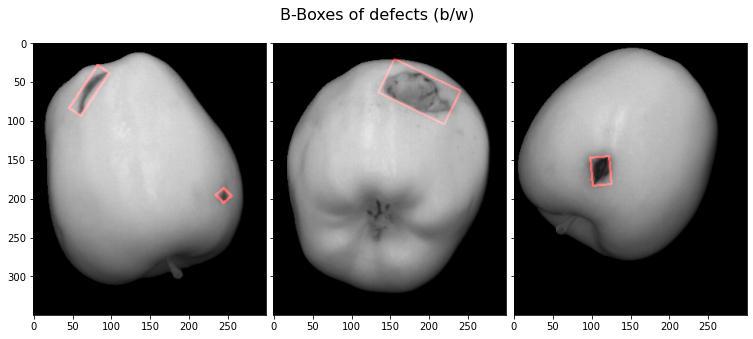

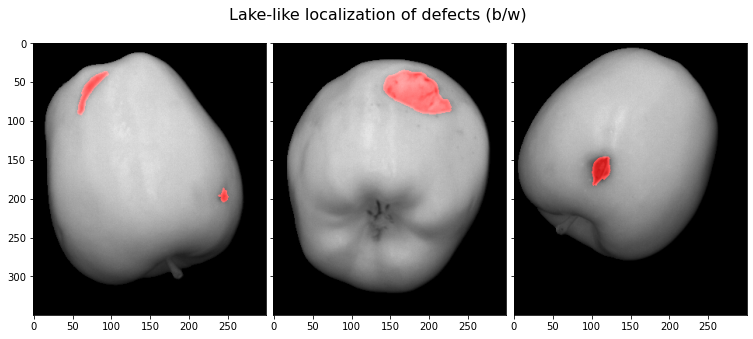

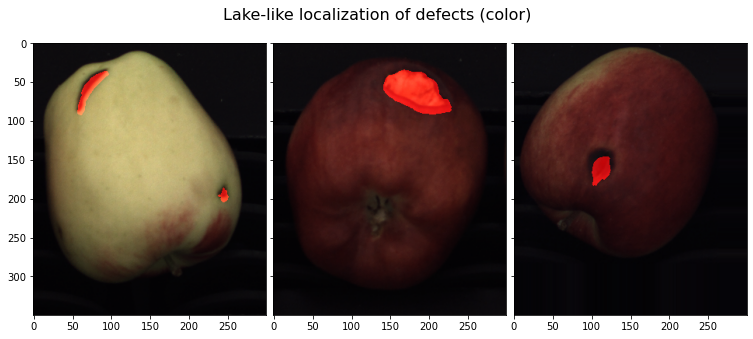

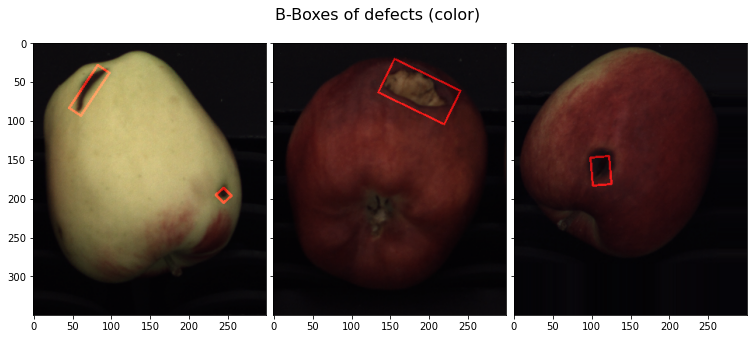

In [22]:
def contourSelection(edge_image, verbose=False, show_output=False):
    # getting connected components following the 8-connected neighbors rule
    contour_list, hierarchy = cv2.findContours(edge_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contour_list_clean = []

    for contour in contour_list:
        # computing the area of the contours (including all black pixels inside)
        area = cv2.contourArea(contour)
        # computing the perimeter of the 
        perimeter = cv2.arcLength(contour,True)

        # avoids division by 0 for compactness
        if area > 0:
          compactness = (perimeter**2)/area

        # selection criterias for contoured blobs

        if (area > 10 and compactness<1000) or area>100:
            contour_list_clean.append(contour)
            if verbose:
                print("selected: ",area, perimeter, compactness)
        elif verbose:
            if area>0:
                print("not selected: ",area, perimeter, compactness)
            else:
                print("not selected: ",area, perimeter)

    if show_output:
        img = np.zeros(edge_image.shape)
        cv2.drawContours(img,contour_list_clean,-1,(255,255,255),1)
        plt.imshow(img, cmap="gray")
        plt.title("Selected Contours")
        plt.show()

    return contour_list_clean

def boundingBoxSelection(out_img_shape, contour_list, verbose=False, show_output=False):
    '''
    In this implementation, the contours in input are closed building a convex hull and
    they're filled with white.
    ____________________
    
    out_img_shape:  the dimensions of the mask in which contours have to be displayed
    contour_list:  a list containing the contour
    '''
    img = np.zeros(out_img_shape)
    resulting_rectangles = []
    resulting_contours = []
    for i in range(len(contour_list)):
        rect = cv2.minAreaRect(contour_list[i])
        box = cv2.boxPoints(rect)
        length = rect[1][0]
        width = rect[1][1]
        biggest_side = max(length,width)
        smallest_side = min(length,width)
        if verbose:
            print("big side/small side = ", biggest_side/smallest_side)

        # selection criteria on bounding rectangle
        if (biggest_side/smallest_side < 3) or (biggest_side*smallest_side)>1000:
            box = np.int0(box)
            cv2.drawContours(img,[box],-1,(255,255,255),2)
            resulting_rectangles.append(rect)
            resulting_contours.append(contour_list[i])
        
        if show_output:
            plt.imshow(img, cmap="gray")
            plt.title()
            plt.show()

    return img, resulting_rectangles, resulting_contours


selected_contours = [contourSelection(i) for i in defects_edges]
selected_contour_bound_boxes = [np.array(boundingBoxSelection(imgs[i].shape, selected_contours[i])[0], dtype=np.uint8) for i in range(len(selected_contours))]
selected_contour_lakes = [boundingBoxSelection(imgs[i].shape, selected_contours[i])[2] for i in range(len(selected_contours))]

# Black & White images + masks overlay show
overlayed_defects_bound_box = [show_masking_effect(selected_contour_bound_boxes[i], cv2.cvtColor(masked_images[i],cv2.COLOR_GRAY2RGB)) for i in range(len(imgs))]

image_selected_contours = [np.array(cv2.drawContours(np.zeros(imgs[i].shape), selected_contour_lakes[i],-1, (255, 255, 255),thickness=cv2.FILLED),dtype=np.uint8) for i in range(len(selected_contours))]

overlayed_defects_lakes = [show_masking_effect(image_selected_contours[i], cv2.cvtColor(masked_images[i],cv2.COLOR_GRAY2RGB)) for i in range(len(imgs))]


plot_images_row(overlayed_defects_bound_box, title = "B-Boxes of defects (b/w)")
plot_images_row(overlayed_defects_lakes, title = "Lake-like localization of defects (b/w)")


# Color images + masks overlay show

overlayed_defects_lakes_color = [show_masking_effect(image_selected_contours[i], color_imgs[i]) for i in range(len(imgs))]
overlayed_defects_bound_box_color = [show_masking_effect(selected_contour_bound_boxes[i], color_imgs[i]) for i in range(len(imgs))]

plot_images_row(overlayed_defects_lakes_color, title = "Lake-like localization of defects (color)")
plot_images_row(overlayed_defects_bound_box_color, title = "B-Boxes of defects (color)")



Little mismatches wrt the color images were expected, as discussed in the chapter *Checking parallax*. The overall result is good, since the detection ends highlighting all the defects without false positives nor false negatives.

## Final defects detection

In this section, the whole described pipeline is applied to the original images. A time-based benchmark is made to give an estimate of the time needed to perform this quality check.

**N.B.:** Real industrial systems usually require low-level implementations (assembly,C++). The benchmark is done to give a kind of "average time / upper bound" with the (limited) number of samples we're given. In-production stage would require an eventual tuning and refinement of the described procedure.

In [23]:
import time
import platform,socket,re,uuid,json,psutil,logging

def detect_defects_apple(img, show_output=True):
    mask = img.copy()
    im = img.copy()
    
    # Applying custom point operator function + otsu + morph operators
    mask = customFunctionOtsuMorph(mask, show_output=show_output)
    
    # Flood filling the binary mask
    mask = floodFillBackground(mask, show_output=show_output)
    
    # Applying the mask to the original grayscale image
    im = cv2.bitwise_and(im,mask)

    # Canny Edge detection (Gauss filter + OpenCV implementation) + Closing
    edges = cannyEdgeDetectionClosing(im,blurring_dim=7,canny_low=60,canny_high=130, show_output=show_output)
    
    # Eroding mask to avoid treating apple main contours
    eroded_mask = erodeMask(mask, show_output=show_output)

    # Found edges - apple main edge
    defects_edges = cv2.bitwise_and(eroded_mask,edges)

    # Contours selection (suppressing non interesting contours)
    selected_contours = contourSelection(defects_edges, False)
    selected_contour_masks, rectangles, _ = boundingBoxSelection(img.shape, selected_contours, show_output=show_output)
    selected_contour_masks =  np.array(selected_contour_masks, dtype=np.uint8)

    # Displaying as overlay the found bounding boxes on the original (masked) image
    overlayed_defects = show_masking_effect(selected_contour_masks, cv2.cvtColor(im,cv2.COLOR_GRAY2RGB), show_output=show_output)

    return overlayed_defects, rectangles


def benchmark_apple_defects_detection(imgs,iterations):
    '''
    This function computes the average elapsed time for the detection process:
    
    imgs: images to which detection has to be applied
    iterations: number of times the detecton has to be performed on the whole set of imgs
    
    returns: the average time for each detection, in seconds
    '''
    start = time.time()
    for i in range(iterations):
      for j in imgs:
        detect_defects_apple(j,show_output=False)

    end = time.time()
    return (end-start)/(iterations*len(imgs))


def getSystemInfo():
    try:
        info={}
        info['platform']=platform.system()
        info['platform-release']=platform.release()
        info['platform-version']=platform.version()
        info['architecture']=platform.machine()
        info['processor']=platform.processor()
        info['ram']=str(round(psutil.virtual_memory().total / (1024.0 **3)))+" GB"
        return json.dumps(info)
    except Exception as e:
        logging.exception(e)

print("Average time for detection: ", benchmark_apple_defects_detection(imgs,10000))
print("Machine in use: ",json.loads(getSystemInfo()))

Average time for detection:  0.005952152975400289
Machine in use:  {'platform': 'Windows', 'platform-release': '10', 'platform-version': '10.0.19044', 'architecture': 'AMD64', 'processor': 'Intel64 Family 6 Model 142 Stepping 9, GenuineIntel', 'ram': '8 GB'}


The elapsed time is less than 0.01 seconds, a quite good result in terms of speed (of course, this has to be compared with the time needed by the mechanical stages involved in the transit of the fruit on the conveyor belt and of the actuators selecting the intact/damaged fruit path).